In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel, DotProduct, Matern
from sklearn.model_selection import train_test_split
from helpers.create_histograms import load_histogram
from helpers.visualize_data import plot_simple_histogram

In [2]:
# load already made histograms with some cut on m_mumu
path_to_hist = "data/generated_histograms"
hist_name = "my_hist"
hist_labels = ["Background", "Signal", "Data"]

hists = {}

for hist_label in hist_labels:
    hists[hist_label] = load_histogram(path_to_hist, hist_name, hist_label)

In [3]:
gamma = 10.0

d_bin_centers, d_bin_edges, d_bin_values, d_bin_errors = hists["Data"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["AsimovData"] = [
    d_bin_centers,
    d_bin_edges,
    d_bin_values + gamma * s_bin_values,
    np.sqrt(d_bin_errors ** 2 + (gamma * s_bin_errors) ** 2)
]
hists["AsimovSignal"] = [
    s_bin_centers,
    s_bin_edges,
    s_bin_values + gamma * s_bin_values,
    s_bin_errors if gamma == 0.0 else gamma * s_bin_errors,
]

In [4]:
# get histogram data
blind_hists = ["Data", "AsimovData"]

for hist_name in blind_hists:
    bin_centers, bin_edges, bin_values, bin_errors = hists[hist_name]
    
    blind_centers_m = (bin_centers <= 120.0) | (bin_centers >= 130.0) # bool mask for centers
    blind_edges_m = (bin_edges <= 120.0) | (bin_edges > 130.0) # bool mask for edges
    
    # make new dict entry 
    hists[f"Blind{hist_name}"] = [
        bin_centers[blind_centers_m],
        bin_edges[blind_edges_m],
        bin_values[blind_centers_m],
        bin_errors[blind_centers_m],
    ]

In [5]:
b_bin_centers, b_bin_edges, b_bin_values, b_bin_errors = hists["Background"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["SignalPlusBackgroundMC"] = [
    b_bin_centers,
    b_bin_edges,
    b_bin_values + s_bin_values,
    np.sqrt(b_bin_errors ** 2 + s_bin_errors ** 2),
]

In [6]:
print(hists.keys())

dict_keys(['Background', 'Signal', 'Data', 'AsimovData', 'AsimovSignal', 'BlindData', 'BlindAsimovData', 'SignalPlusBackgroundMC'])


### Fitanje GPR na podatke

In [7]:
# library for error propagation on numpy arrays
from uncertainties import unumpy as unp

In [8]:
# get input data
bin_centers, bin_edges, bin_values, bin_errors = hists["AsimovData"]
b_bin_centers, b_bin_edges, b_bin_values, b_bin_errors = hists["BlindAsimovData"]

In [9]:
# Uporabimo "blind" podatke kot učno množico
X_train = b_bin_centers.reshape(-1, 1)
y_train = unp.uarray(b_bin_values, b_bin_errors)

# --- Min-max normalizacija ---
x_min, x_max = np.min(X_train), np.max(X_train)
X_train = (X_train - x_min) / (x_max - x_min)

y_nom = unp.nominal_values(y_train)
y_min, y_max = np.min(y_nom), np.max(y_nom)
y_train = (y_train - y_min) / (y_max - y_min)
y_train, y_train_var = unp.nominal_values(y_train), unp.std_devs(y_train)**2

In [10]:
# Lahko shraniš parametre za kasnejšo denormalizacijo GP napovedi
scaler_params = {
    "x_min": x_min, "x_max": x_max,
    "y_min": y_min, "y_max": y_max
}

In [11]:
print(scaler_params)

{'x_min': np.float32(110.41667), 'x_max': np.float32(159.58334), 'y_min': np.float64(9819.0419921875), 'y_max': np.float64(102960.6484375)}


In [12]:
# define kernel and model
kernel_rbf = ConstantKernel(
    1.0,
    constant_value_bounds=(1e-3, 1e3),
) * RBF(
    length_scale=1.0,
    length_scale_bounds=(1e-3, 1e3),
)

kernel_matern = ConstantKernel(
    1.0,
    constant_value_bounds=(1e-3, 1e3),
) * Matern(
    1.0,
    length_scale_bounds=(1e-3, 1e3),
    nu=1.5,
)

gpr_model = GaussianProcessRegressor(kernel=kernel_matern, alpha=y_train_var, n_restarts_optimizer=0)

In [13]:
# fit the model
gpr_model.fit(X_train, y_train)

# optimized kernel parameters
gpr_model.kernel_

5.58**2 * Matern(length_scale=5.45, nu=1.5)

In [14]:
# define test interval data with same scaling as inputs
X_test = bin_centers.reshape(-1, 1)
# --- Min-max normalizacija ---
x_min_test, x_max_test = np.min(X_test), np.max(X_test)
X_test = (X_test - x_min_test) / (x_max_test - x_min_test)

# run predict on model
y_mean, y_std = gpr_model.predict(X_test, return_std=True)

In [15]:
# rescale back from -1 to 1
X_train = X_train * (scaler_params['x_max'] - scaler_params['x_min']) + scaler_params['x_min']
y_train = y_train * (scaler_params['y_max'] - scaler_params['y_min']) + scaler_params['y_min']

X_test = X_test * (x_max_test - x_min_test) + x_min_test

y = unp.uarray(y_mean, y_std)
y_nom = unp.nominal_values(y_train)
y_min, y_max = np.min(y_nom), np.max(y_nom)
y = y * (y_max - y_min) + y_min
y_mean, y_std = unp.nominal_values(y), unp.std_devs(y)

In [16]:
# save results to hists dict
hists["gpr"] = [X_test[:, 0], bin_edges, y_mean, y_std]

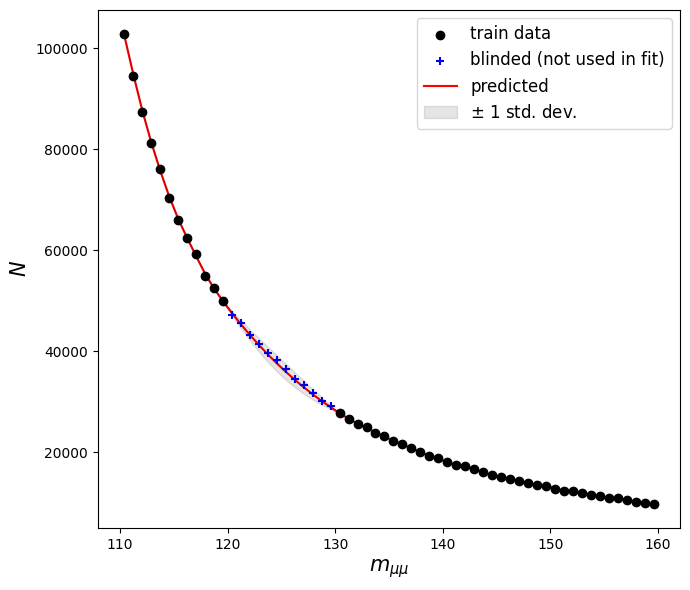

In [17]:
plt.figure(figsize=(7, 6))

plt.scatter(X_train[:, 0], y_train, c="k", label="train data", zorder=2)
plt.scatter(bin_centers, bin_values, c="b", marker="+", label="blinded (not used in fit)", zorder=1)
plt.plot(X_test[:, 0], y_mean, c="r", label="predicted", zorder=0)
plt.fill_between(
    X_test[:, 0],
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel(r"$N$", fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()

In [18]:
data = hists["AsimovData"]
gpr_background = hists["gpr"]

signal_x, edges = data[0], data[1]

# do smooth background subtraction
signal = data[2] - gpr_background[2]

# calculate errors from subtraction
signal_std = np.sqrt(data[3]**2 + gpr_background[3]**2)

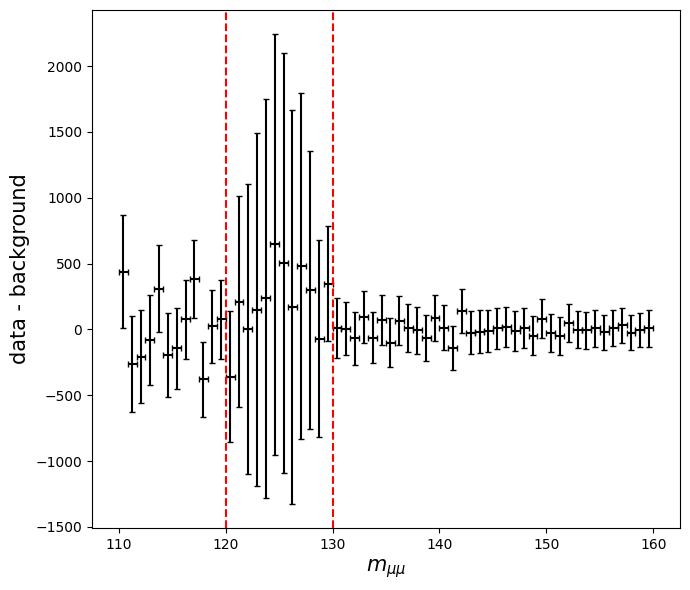

In [19]:
plt.figure(figsize=(7, 6))

plt.errorbar(
    x=signal_x,
    y=signal,
    xerr=np.diff(edges)[0] / 2,
    yerr=signal_std,
    linestyle="None",
    marker="o",
    ms=0,
    c="k",
    capsize=2,
)

plt.axvline(120.0, c="r", ls="--")
plt.axvline(130.0, c="r", ls="--")

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel("data - background", fontsize=15)

plt.tight_layout()

In [50]:
## Tipi normalizacije in denormalizacije

def minmax_normalize(X, y):
    """
    Izvede min-max normalizacijo vhodov X in izhodov y (lahko z napakami).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray ali unumpy.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : np.ndarray
        Normalizirani vhodi
    y_norm : np.ndarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za kasnejšo inverzno transformacijo (x_min, x_max, y_min, y_max)
    """

    # --- Če y vsebuje napake (unumpy array) ---
    y_nom = unp.nominal_values(y)

    # --- Normalizacija ---
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(y_nom), np.max(y_nom)

    X_norm = (X - x_min) / (x_max - x_min)
    y_norm = (y - y_min) / (y_max - y_min)

    params = {"x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max}

    return X_norm, y_norm, params


def minmax_inverse(X_norm, y_norm, params):
    """
    Obrne min-max normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : np.ndarray
        Normalizirani podatki
    params : dict
        Slovar z mejami: {"x_min", "x_max", "y_min", "y_max"}

    Vrne:
    -----
    X, y, y_std : np.ndarray
        Nenormalizirani podatki
    """

    X = X_norm * (params["x_max"] - params["x_min"]) + params["x_min"]
    y = y_norm * (params["y_max"] - params["y_min"]) + params["y_min"]

    return X, y


def standard_normalize(X, y):
    """
    Izvede standardno normalizacijo vhodov X in izhodov y (z upoštevanjem napak).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray ali unumpy.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    y_nom = unp.nominal_values(y)

    # --- Normalizacija ---
    x_mean, x_std = np.mean(X), np.std(X)
    y_mean, y_std_nom = np.mean(y_nom), np.std(y_nom)

    X_norm = (X - x_mean) / x_std
    y_norm = (y - y_mean) / y_std_nom

    params = {"x_mean": x_mean, "x_std": x_std,
              "y_mean": y_mean, "y_std": y_std_nom}
    
    return X_norm, y_norm, params


def standard_inverse(X_norm, y_norm, params):
    """
    Obrne standardno normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : unp.undarray
        Normalizirani podatki
    params : dict
        Slovar s povprečji in standardnimi odkloni

    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    X = X_norm * params["x_std"] + params["x_mean"]
    y = y_norm * params["y_std"] + params["y_mean"]

    return X, y


def log_normalize(X, y):
    """
    Izvede logaritemsko normalizacijo vhodov X in izhodov y (z upoštevanjem napak).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    # --- Normalizacija ---
    X_norm = np.log(X)
    y_norm = unp.log(y)
    
    params = {}

    return X_norm, y_norm, params


def log_inverse(X_norm, y_norm, params):
    """
    Obrne standardno normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : unp.uarray
        Normalizirani podatki

    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    X = unp.exp(X_norm)
    y = unp.exp(y_norm)

    return X, y


def normalize(X, y, norm):
    """
    Noamrlizira podatke za par različnih tipov normalizacije

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray
        Izhodne vrednosti (lahko z napakami)
    norm : str
        Tip normalizacije "minmax", "standard", "log"
    
    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    if norm == "minmax":
        X_norm, y_norm, params = minmax_normalize(X, y)
        return X_norm, y_norm, params
    
    elif norm == "standard":
        X_norm, y_norm, params = standard_normalize(X, y)
        return X_norm, y_norm, params
    
    elif norm == "log":
        X_norm, y_norm, params = log_normalize(X, y)
        return X_norm, y_norm, params
    
    else:
        return print("Tega tipa normalizacije ni v meniju.")
    

def denormalize(X_norm, y_norm, params, norm):
    """
    Denoamrlizira podatke za par različnih tipov denormalizacije

    Parametri:
    ----------
    X_norm, y_norm : unp.undarray
        Normalizirani podatki
    params : dict
        Slovar s potrebnimi parametri
    norm : str
        Tip normalizacije "minmax", "standard", "log"
    
    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    if norm == "minmax":
        X, y = minmax_inverse(X_norm, y_norm, params)
        return X, y
    
    elif norm == "standard":
        X, y = standard_inverse(X_norm, y_norm, params)
        return X, y
    
    elif norm == "log":
        X, y = log_inverse(X_norm, y_norm, params)
        return X, y
    
    else:
        return print("Tega tipa denormalizacije ni v meniju.")
    

In [51]:
def train_gp(X, y, norm, kernel, **kernel_kwargs):
    """
    Določi model za Gaussovske procese

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray ali unumpy.uarray
        Izhodne vrednosti (lahko z napakami)
    norm : str
        Normalizacijska metoda. Ena od "minmax", "standard" in "log"
    kernel : str
        Jedro za Gaussovske procese. Eno od "RBF", "Matern", "RQ", "ExpSineSquared" in "DotProduct"

    Vrne:
    -----
    gpr_model : GaussianProcessRegressor
        Model Gaussovskih procesov
    params : dict
        Parametri za inverzno transformacijo 
    """

    # Preprocess X and y
    X_norm, y_norm, params = normalize(X, y, norm)

    # --- Izbor jedra ---
    kernels = {
        "RBF": RBF,
        "Matern": Matern,
        "RQ": RationalQuadratic,
        "ExpSineSquared": ExpSineSquared,
        "DotProduct": DotProduct
    }

    base_kernel = kernels[kernel](length_scale=1.0,
        length_scale_bounds=(1e-3, 1e3),
        **kernel_kwargs)

    ker = ConstantKernel(
        1.0,
        constant_value_bounds=(1e-3, 1e3),
    ) * base_kernel

    # --- GP regresor ---
    gpr_model = GaussianProcessRegressor(
        kernel=ker,
        alpha=unp.std_devs(y_norm)**2,
        n_restarts_optimizer=0
    )

    # fit the model
    gpr_model.fit(unp.nominal_values(X_norm), unp.nominal_values(y_norm))

    return gpr_model, params


In [52]:
# Uporabimo "blind" podatke kot učno množico
X_train = b_bin_centers.reshape(-1, 1)
y_train = unp.uarray(b_bin_values, b_bin_errors)

gpr_model, params = train_gp(X_train, y_train, "minmax", "RBF")

In [53]:
# define test interval data with same scaling as inputs
X_test = bin_centers.reshape(-1, 1)
X_test, _, params_test = normalize(X_test, y_train, "minmax")

# run predict on model
y_mean, y_std = gpr_model.predict(X_test, return_std=True)
y = unp.uarray(y_mean, y_std)

In [54]:
# rescale back from log
X_train, y_train = denormalize(X_train, y_train, params, "minmax")
y_train, y_train_std = unp.nominal_values(y_train), unp.std_devs(y_train)

X_test, y = denormalize(X_test, y, params_test, "minmax")
y_mean, y_std = unp.nominal_values(y), unp.std_devs(y)

In [55]:
# save results to hists dict
hists["gpr"] = [X_test[:, 0], bin_edges, y_mean, y_std]

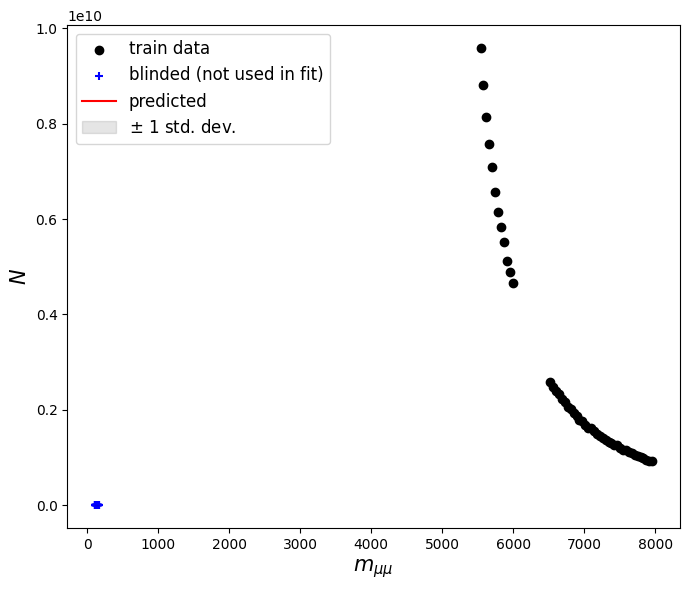

In [58]:
plt.figure(figsize=(7, 6))

plt.scatter(X_train[:, 0], y_train, c="k", label="train data", zorder=2)
plt.scatter(bin_centers, bin_values, c="b", marker="+", label="blinded (not used in fit)", zorder=1)
plt.plot(X_test[:, 0], y_mean, c="r", label="predicted", zorder=0)
plt.fill_between(
    X_test[:, 0],
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel(r"$N$", fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()